## Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from pathlib import Path
from scipy import stats
from skimage import io, filters
from skimage import color
from skimage import img_as_float
from skimage.util import view_as_windows

## Load data

In [4]:
# Path to data
path_to_data = Path.cwd() / 'data'

# Read train data from csv
train_file_name = path_to_data / 'train.csv'
train_names = pd.read_csv(train_file_name, index_col=0)
del train_names.index.name

# Read flower names from csv
flower_names = pd.read_csv(path_to_data / 'flower_names.csv', header=0, index_col=0)
del flower_names.index.name

# Load multiple images (image collection. loads on demand)
ic = io.ImageCollection(str(path_to_data / 'train' / '*.jpg'))

## Helper functions (for plotting)

In [5]:
def plot_sample_images(IC):
    f, axes = plt.subplots(nrows=3, ncols=len(IC) // 3 + 1, figsize=(20, 5))

    axes = axes.ravel()

    for ax in axes:
        ax.axis('off')

    for i, image in enumerate(IC):
        axes[i].imshow(image, cmap='gray')
        flower_id = int(os.path.basename(IC.files[i])[:-4])
        flower_category = train_names.loc[flower_id].category
        flower_name = flower_names.loc[flower_category].Name
        axes[i].set_title(flower_name)

    plt.tight_layout()
    plt.show()

In [6]:
def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

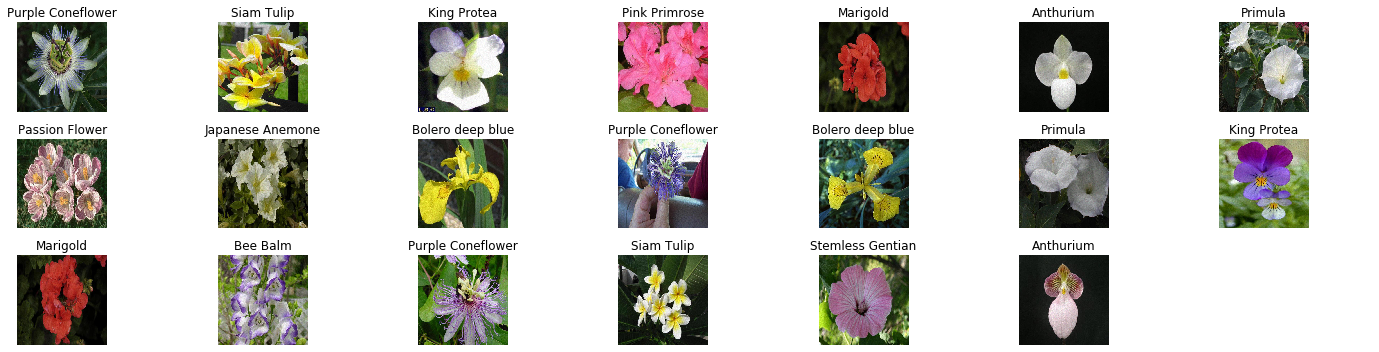

In [7]:
plot_sample_images(ic[:20]) # Plot first 20 images

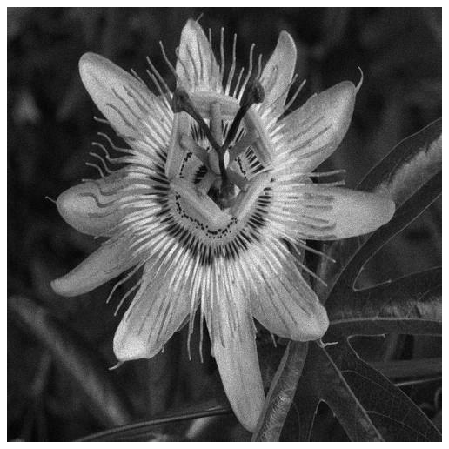

In [8]:
gray_image = color.rgb2gray(ic[0])
image_show(gray_image);

## Color Features

18 features; for each of the RGB channels:
- mean
- median
- mode
- standard deviation
- skewness
- kurtosis

6 additional features: 
- red range
- blue range
- green range
- red-to-blue range
- blue-to-green range
- red-to-green range

In [9]:
def color_features(img):
    """
    img: colored image (3D-numpy array)
    returns: descriptive statistics as features
    """
    image = img_as_float(img).copy()
    
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    
    f_mean = list(map(lambda x: np.mean(x), [R,G,B]))
    f_median = list(map(lambda x: np.median(x), [R,G,B]))
    f_mode = list(map(lambda x: stats.mode(x.ravel())[0][0], [R,G,B]))
    f_std = list(map(lambda x: np.std(x), [R,G,B]))
    f_skew = list(map(lambda x: stats.skew(x.ravel()), [R,G,B]))
    f_kurt = list(map(lambda x: stats.kurtosis(x.ravel()), [R,G,B]))
    
    f_red_range = R.max() - R.min()
    f_green_range = G.max() - G.min()
    f_blue_range = B.max() - B.min()
    f_red_to_blue_range = f_red_range/(f_blue_range+1)
    f_blue_to_green_range = f_blue_range/(f_green_range+1)
    f_red_to_green_range = f_red_range/(f_green_range+1)
    
    f_color_ranges = [f_red_range, f_green_range, f_blue_range, 
                      f_red_to_blue_range, f_blue_to_green_range, f_red_to_green_range]
    
#     print(f_mean)
#     print(f_median)
#     print(f_mode)
#     print(f_std)
#     print(f_skew)
#     print(f_kurt)
#     print(f_color_ranges)
    
    return f_mean + f_median + f_mode + f_std + f_skew + f_kurt + f_color_ranges

## Does the image has metada?

I will use `exif` module to check of the images have metada.

In [10]:
from exif import Image
with open(ic.files[10], 'rb') as image_file:
     my_image = Image(image_file)

my_image.has_exif

False

Images do not have metada.

## Edge Features

In [52]:
def edge_score(img):
    image = img_as_float(color.rgb2gray(img)).copy()
    edges = filters.sobel(image)
    thresh = filters.threshold_isodata(edges) 
    edges = edges > thresh
#     image_show(edges)
    return edges.sum()/edges.size

In [53]:
edge_score(ic[27])

0.030388

In [82]:
def window_and_average(img, window_length=25, step_size=25):
    windows = view_as_windows(hog_image_rescaled, window_length, step_size)
    return np.mean(windows, axis=(2,3)).ravel()

In [83]:
window_and_average(hog_image_rescaled).shape

(400,)

## Histogram of Oriented Gradients (HOG)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


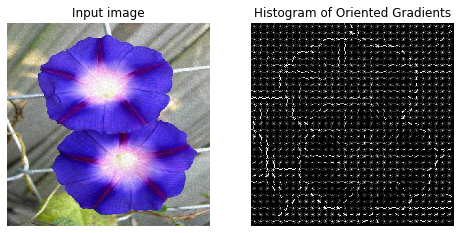

In [18]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = ic[101]#data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [19]:
fd.shape

(7688,)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12bda14e0>)

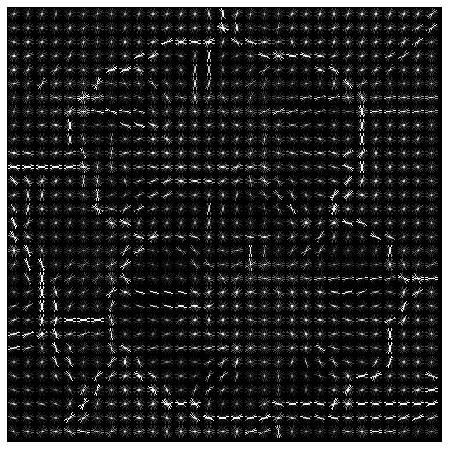

In [20]:
image_show(hog_image_rescaled)

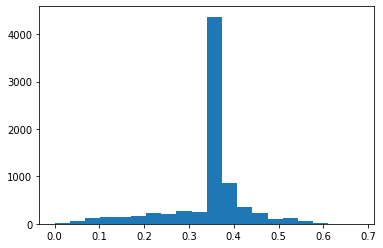

In [21]:
plt.hist(fd, bins=20);

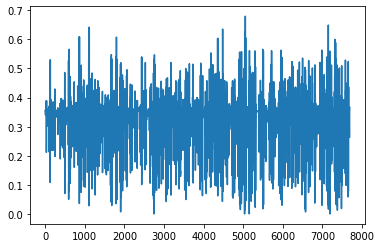

In [22]:
plt.plot(fd)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129e12208>)

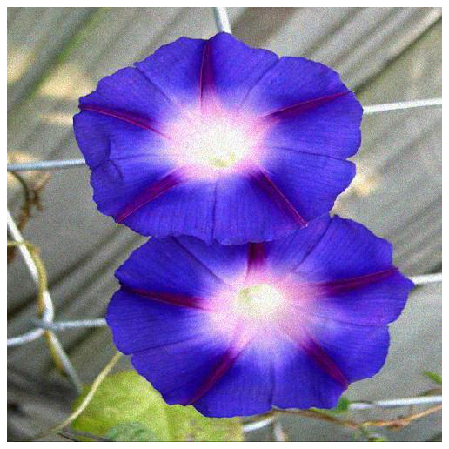

In [23]:
image_show(image)

In [165]:
pproc = []
for i, image in enumerate(ic):
    pproc.append(color_features(image))
    if i%100 == 0:
        print(ic.files[i])

/Users/sean/PycharmProjects/Flower Nerd/data/train/0.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/100.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/200.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/300.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/400.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/500.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/600.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/700.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/800.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/900.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1000.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1100.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1200.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1300.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1400.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1500.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/1

/Users/sean/PycharmProjects/Flower Nerd/data/train/13700.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/13800.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/13900.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14000.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14100.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14200.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14300.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14400.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14500.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14600.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14700.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14800.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/14900.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/15000.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/15100.jpg
/Users/sean/PycharmProjects/Flower Nerd/data/train/15200.jpg
/Users/sean/PycharmProje

In [159]:
np.array(pproc).shape

(12, 24)

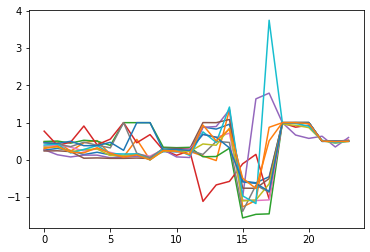

In [161]:
plt.plot(np.array(pproc).T);

In [164]:
6%4

2

In [166]:
len(pproc)

18540

In [170]:
df = pd.DataFrame(pproc)

In [173]:
df.to_csv('training.csv')

In [172]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.262854,0.305407,0.251877,0.141176,0.203922,0.133333,0.078431,0.145098,0.066667,0.219417,...,0.957598,-0.570442,-0.618062,-0.456079,0.988235,1.000000,1.000000,0.494118,0.500000,0.494118
1,0.485818,0.480993,0.232216,0.458824,0.517647,0.145098,0.082353,0.549020,0.000000,0.291142,...,1.345337,-1.266983,-1.093984,0.875042,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000
2,0.492944,0.504932,0.448928,0.525490,0.501961,0.388235,1.000000,1.000000,1.000000,0.338561,...,0.312504,-1.563830,-1.467380,-1.454424,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000
3,0.771191,0.387396,0.475808,0.909804,0.403922,0.556863,1.000000,0.458824,0.678431,0.259517,...,-0.580884,-0.107602,0.145823,-1.057183,0.992157,0.878431,0.933333,0.513185,0.496868,0.528184
4,0.272163,0.135960,0.077235,0.125490,0.125490,0.054902,0.066667,0.098039,0.031373,0.270839,...,1.345141,-0.995206,1.640437,1.794731,1.000000,0.666667,0.576471,0.634328,0.345882,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18535,0.442838,0.417018,0.411839,0.309804,0.349020,0.266667,0.011765,0.019608,0.000000,0.385270,...,0.282541,-1.702815,-1.456792,-1.682512,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000
18536,0.743494,0.494330,0.514359,0.772549,0.462745,0.478431,0.827451,0.000000,0.835294,0.116978,...,-0.063575,-0.295764,-1.515767,-1.457534,0.764706,1.000000,1.000000,0.382353,0.500000,0.382353
18537,0.333424,0.250181,0.196917,0.168627,0.203922,0.058824,0.000000,0.000000,0.000000,0.330508,...,1.177196,-1.015230,0.056075,0.077378,1.000000,1.000000,0.984314,0.503953,0.492157,0.500000
18538,0.405182,0.241790,0.206664,0.333333,0.180392,0.133333,0.207843,0.000000,0.109804,0.232717,...,1.516165,0.441885,1.767877,2.892931,0.921569,1.000000,1.000000,0.460784,0.500000,0.460784


## Rescale the image

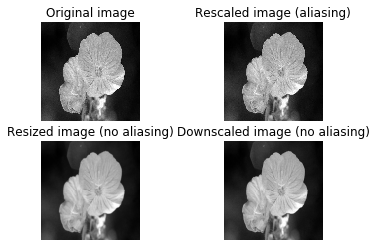

In [176]:
from skimage.transform import rescale, resize, downscale_local_mean

image = img_as_float(color.rgb2gray(ic[100])).copy()

image_rescaled = rescale(image, 0.2, anti_aliasing=False)
image_resized = resize(image, (image.shape[0] // 5, image.shape[1] // 5), anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (5, 5))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('equal')
ax[0].axis('off')

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")
ax[1].axis('equal')
ax[1].axis('off')

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")
ax[2].axis('equal')
ax[2].axis('off')

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")
ax[3].axis('equal')
ax[3].axis('off')

plt.show()

In [182]:
image_rescaled.shape

(100, 100)

In [180]:
image_resized = resize(image, (image.shape[0] // 5, image.shape[1] // 5), anti_aliasing=True)

In [181]:
image_downscaled = downscale_local_mean(image, (5, 5))